In [903]:
import pandas as pd
import requests
import time
import datetime
import json
import ast
import subprocess


def spark_get_app_jobs(app_id):
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications/%s/jobs"%(spark_hists_host,spark_hists_port,
                                                      app_id)
    return requests.get(url = URL).json()
    
def get_spark_job(app_id, jobid):
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications/%s/jobs/%d"%(spark_hists_host,spark_hists_port,
                                                      app_id, jobid)
    return requests.get(url = URL).json()

def spark_get_app_stages(app_id):
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications/%s/stages"%(spark_hists_host, spark_hists_port, 
                                                      app_id)
    return requests.get(url = URL).json()

def spark_get_app_stage(app_id, stage_id):
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications/%s/stages/%d"%(spark_hists_host, spark_hists_port, 
                                                      app_id, stage_id)
    return requests.get(url = URL).json()


def get_spark_apps():
    spark_hists_host='neu-3-1'
    spark_hists_port=18080
    URL = "http://%s:%d/api/v1/applications"%(spark_hists_host,spark_hists_port)
    return requests.get(url = URL).json()

def get_dag_from_log(app_id):
    cat = subprocess.Popen(["hadoop", "fs", "-cat", '/local0/spark-logs/%s'%(app_id)], 
                           stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = cat.communicate()
    stage_inputs = {}
    job_dag_str = ''
    for l in stdout.decode().split('\n'):
        l = l.replace('\n', '')
        if l.startswith('{"Event":"SparkListenerJobStart"'):
            job = json.loads(l)
            for stage in job['Stage Infos']:
                for rdd in stage["RDD Info"]:
                    if not rdd["Parent IDs"]:
                        stage_inputs[stage['Stage ID']] = rdd['Name'].split('.')[0].split('/')[-1]                
                if len(stage['Parent IDs']) == 0:
                    job_dag_str += 'j:%s,e:->%s\n'%(job['Job ID'],stage['Stage ID'])
                    continue
                for pid in stage['Parent IDs']:
                    job_dag_str += 'j:%s,e:%s->%s\n'%(job['Job ID'],pid,stage['Stage ID'])                
    print('Application %s has been processed'%(app_id))
    return job_dag_str, stage_inputs

app_name_to_id = {}
appid_to_stagestables = {}
for app in get_spark_apps():
    if not app['name'].startswith('framework:spark'):
        continue
    app_dag_str, stages_tables = get_dag_from_log(app['id']) 
    app_name_to_id[app['name']] = {
        'app_name' : app['name'],
        'app_id' : app['id'],
        'app_start_time': app['attempts'][0]['startTimeEpoch'],
        'app_completion_time': app['attempts'][0]['endTimeEpoch'],
        'app_dag': app_dag_str}
    appid_to_stagestables[app['id']] = stages_tables
    for i in app['name'].split('-'):
        app_name_to_id[app['name']][i.split(':')[0]] = i.split(':')[1]

Application app-20200906205822-0296 has been processed
Application app-20200906205231-0295 has been processed
Application app-20200906204446-0294 has been processed
Application app-20200906203015-0292 has been processed
Application app-20200906202643-0291 has been processed
Application app-20200906202345-0290 has been processed
Application app-20200906202223-0289 has been processed
Application app-20200906202021-0288 has been processed
Application app-20200906201651-0287 has been processed
Application app-20200906201007-0286 has been processed
Application app-20200906200438-0285 has been processed
Application app-20200906200232-0284 has been processed
Application app-20200906195516-0283 has been processed
Application app-20200906195137-0282 has been processed
Application app-20200906194404-0281 has been processed
Application app-20200906193403-0280 has been processed
Application app-20200906192726-0279 has been processed
Application app-20200906192020-0278 has been processed
Applicatio

Application app-20200905184332-0144 has been processed
Application app-20200905183848-0143 has been processed
Application app-20200905183443-0142 has been processed
Application app-20200905183147-0141 has been processed
Application app-20200905182931-0140 has been processed
Application app-20200905182508-0139 has been processed
Application app-20200905182030-0138 has been processed
Application app-20200905181709-0137 has been processed
Application app-20200905181303-0136 has been processed
Application app-20200905180847-0135 has been processed
Application app-20200905180720-0134 has been processed
Application app-20200905180519-0133 has been processed
Application app-20200905180057-0132 has been processed
Application app-20200905175622-0131 has been processed
Application app-20200905175345-0130 has been processed
Application app-20200905174956-0129 has been processed
Application app-20200905174635-0128 has been processed
Application app-20200905173653-0127 has been processed
Applicatio

In [905]:
fpath='/local0/Kariz/expriments/runtime_prediction/tpch/runtime.pred.spark.stats.csv'
kariz_apps = pd.read_csv(fpath)
kariz_apps.head(5)

,app_name
0,framework:spark-name:tpch17-bw:40Gbps-ds:-stride:90-random:hszhwpis
1,framework:spark-name:tpch9-bw:5Gbps-ds:20G-stride:50-random:munbjefq
2,framework:spark-name:tpch3-bw:5Gbps-ds:20G-stride:100-random:xqrhrjjz
3,framework:spark-name:tpch22-bw:10Gbps-ds:20G-stride:90-random:sedbveld
4,framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh


In [906]:
def get_spark_app_history(row, app_stats):
    if row['app_name'] not in app_name_to_id:
        return 
    
    app_meta = app_name_to_id[row['app_name']]
    app_id = app_name_to_id[row['app_name']]['app_id']
    
    print('Application', app_id, 'with name', row['app_name'], 'to be processed')
    
    # jobs within this application
    jobs = spark_get_app_jobs(app_id)
    for job in jobs:
        job_start_time = time.mktime(datetime.datetime.strptime(job['submissionTime'],
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
        job_completion_time = time.mktime(datetime.datetime.strptime(job['completionTime'],
                                                     "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())

        stages = job['stageIds']
        for sid in stages:
            stage = spark_get_app_stage(app_id, sid)[0]
            
            if stage['status'] == 'SKIPPED':
                continue
            
            stage_submit_time = time.mktime(datetime.datetime.strptime(stage['submissionTime'],
                                                         "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
            stage_start_time = time.mktime(datetime.datetime.strptime(stage['firstTaskLaunchedTime'],
                                                         "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
            stage_completion_time = time.mktime(datetime.datetime.strptime(stage['completionTime'],
                                                         "%Y-%m-%dT%H:%M:%S.%fGMT").timetuple())
            stage_queue_time = stage_start_time - stage_submit_time
            stage_run_time = stage_completion_time - stage_start_time

            stage_stats = {
                      'job_id': job['jobId'], 
                      'job_submission_time': job_start_time,
                      'job_completion_time': job_completion_time,
                      'job_stage_ids': job['stageIds'],
                      'stage_id': stage['stageId'], 'numTasks': stage['numTasks'], 
                      'stage_submission_time': stage_submit_time, 
                      'stage_start_time': stage_start_time, 
                      'stage_completion_time': stage_completion_time,
                      'stage_queue_time': stage_queue_time,
                      'stage_run_time': stage_run_time,
                      'stage_input_bytes': stage['inputBytes'], 
                      'outputBytes': stage['outputBytes'], 
                      'stage_shuffle_read_bytes': stage['shuffleReadBytes'], 
                      'stage_shuffle_write_bytes': stage['shuffleWriteBytes'],
                      'stage_rdds': stage['rddIds']}
            stage_stats.update(app_meta)
            app_stats.append(stage_stats)

application_stats = []
kariz_apps.apply(get_spark_app_history, axis=1, app_stats=application_stats)
df = pd.DataFrame(application_stats)


Application app-20200905103633-0009 with name framework:spark-name:tpch9-bw:5Gbps-ds:20G-stride:50-random:munbjefq to be processed
Application app-20200905104304-0010 with name framework:spark-name:tpch3-bw:5Gbps-ds:20G-stride:100-random:xqrhrjjz to be processed
Application app-20200905104607-0011 with name framework:spark-name:tpch22-bw:10Gbps-ds:20G-stride:90-random:sedbveld to be processed
Application app-20200905104849-0012 with name framework:spark-name:tpch13-bw:40Gbps-ds:20G-stride:80-random:ufhowguh to be processed
Application app-20200905105112-0013 with name framework:spark-name:tpch11-bw:5Gbps-ds:20G-stride:60-random:phbqgajg to be processed
Application app-20200905105312-0014 with name framework:spark-name:tpch4-bw:1Gbps-ds:20G-stride:25-random:mjqwwtnr to be processed
Application app-20200905114706-0015 with name framework:spark-name:tpch3-bw:10Gbps-ds:20G-stride:10-random:jfmaevlu to be processed
Application app-20200905114946-0016 with name framework:spark-name:tpch20-bw

Application app-20200905172139-0122 with name framework:spark-name:tpch6-bw:20Gbps-ds:32G-stride:30-random:fibkbexf to be processed
Application app-20200905172313-0123 with name framework:spark-name:tpch10-bw:5Gbps-ds:32G-stride:10-random:ivhwekgg to be processed
Application app-20200905172800-0124 with name framework:spark-name:tpch18-bw:20Gbps-ds:32G-stride:80-random:vmanmvwn to be processed
Application app-20200905172943-0125 with name framework:spark-name:tpch3-bw:20Gbps-ds:32G-stride:0-random:dqlycaka to be processed
Application app-20200905173415-0126 with name framework:spark-name:tpch16-bw:5Gbps-ds:32G-stride:90-random:ckqzurdf to be processed
Application app-20200905173653-0127 with name framework:spark-name:tpch20-bw:40Gbps-ds:32G-stride:40-random:fanbmydw to be processed
Application app-20200905174635-0128 with name framework:spark-name:tpch8-bw:10Gbps-ds:32G-stride:25-random:shtsvktc to be processed
Application app-20200905174956-0129 with name framework:spark-name:tpch15-b

Application app-20200906090723-0184 with name framework:spark-name:tpch16-bw:1Gbps-ds:20G-stride:25-random:pigkwyxe to be processed
Application app-20200906091027-0185 with name framework:spark-name:tpch5-bw:40Gbps-ds:20G-stride:80-random:uytgvwqs to be processed
Application app-20200906091336-0186 with name framework:spark-name:tpch10-bw:1Gbps-ds:20G-stride:50-random:ajvajwru to be processed
Application app-20200906091925-0187 with name framework:spark-name:tpch13-bw:20Gbps-ds:32G-stride:90-random:civaqyqk to be processed
Application app-20200906092332-0188 with name framework:spark-name:tpch21-bw:5Gbps-ds:32G-stride:80-random:gxmkpbre to be processed
Application app-20200906092841-0189 with name framework:spark-name:tpch11-bw:20Gbps-ds:32G-stride:90-random:omlevyen to be processed
Application app-20200906093228-0190 with name framework:spark-name:tpch19-bw:10Gbps-ds:32G-stride:70-random:pjqdfpco to be processed
Application app-20200906093347-0191 with name framework:spark-name:tpch12

Application app-20200906171302-0247 with name framework:spark-name:tpch2-bw:1Gbps-ds:20G-stride:0-random:iefjcksc to be processed
Application app-20200906171620-0248 with name framework:spark-name:tpch10-bw:5Gbps-ds:20G-stride:80-random:hbsfdbth to be processed
Application app-20200906171910-0249 with name framework:spark-name:tpch12-bw:20Gbps-ds:20G-stride:70-random:vomhcvyk to be processed
Application app-20200906172105-0250 with name framework:spark-name:tpch3-bw:1Gbps-ds:20G-stride:20-random:yvncqfak to be processed
Application app-20200906172522-0251 with name framework:spark-name:tpch18-bw:20Gbps-ds:20G-stride:50-random:htdianjf to be processed
Application app-20200906172704-0252 with name framework:spark-name:tpch20-bw:20Gbps-ds:20G-stride:10-random:bdfbbknt to be processed
Application app-20200906173213-0253 with name framework:spark-name:tpch5-bw:10Gbps-ds:32G-stride:100-random:nhissvha to be processed
Application app-20200906175232-0254 with name framework:spark-name:tpch21-b

In [907]:
print(df.columns)

df['app_runtime'] = df['app_completion_time'] - df['app_start_time']
df[['app_runtime', 'bw', 'ds', 'stride']].sort_values(by='app_runtime',ascending=False).head(5)

Index(['app_completion_time', 'app_dag', 'app_id', 'app_name',
       'app_start_time', 'bw', 'ds', 'framework', 'job_completion_time',
       'job_id', 'job_stage_ids', 'job_submission_time', 'name', 'numTasks',
       'outputBytes', 'random', 'stage_completion_time', 'stage_id',
       'stage_input_bytes', 'stage_queue_time', 'stage_rdds', 'stage_run_time',
       'stage_shuffle_read_bytes', 'stage_shuffle_write_bytes',
       'stage_start_time', 'stage_submission_time', 'stride'],
      dtype='object')


,app_runtime,bw,ds,stride
1510,525165,1Gbps,64G,0
1519,525165,1Gbps,64G,0
1512,525165,1Gbps,64G,0
1513,525165,1Gbps,64G,0
1514,525165,1Gbps,64G,0


In [908]:
ppath='/local0/Kariz/expriments/runtime_prediction/tpch/runtime.pred.spark.prefetch.csv'
dp = pd.read_csv(ppath)
dp.head(5)

,app_name,path,prefetched,requested,stride
0,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/customer,11,11,10
1,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/lineitem,371,371,10
2,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/nation,0,0,10
3,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/orders,83,83,10
4,framework:spark-name:tpch6-bw:20Gbps-ds:-stride:10-random:yryilqex,pig-tpch/20G/part,11,11,10


In [1028]:
dm = df.groupby('app_id')['name', 'app_dag'].agg('max').reset_index()
pd.set_option("display.max_colwidth",800)

string_to_query=[]
n_uniques = 0
for i in range(1,23):
    for j, dag_str in enumerate(dm[dm['name']=='tpch%d'%(i)].groupby('app_dag').agg('max').reset_index()['app_dag'].values):
        n_uniques += 1
        string_to_query.append({'query': i, 'dag': dag_str, 'index': j, 'id': n_uniques})

sq_df = pd.DataFrame(string_to_query)

sq_df

,dag,id,index,query
0,"j:0,e:->0\nj:0,e:0->1\nj:1,e:->2\nj:1,e:2->3\nj:1,e:3->4\n",1,0,1
1,"j:0,e:->0\nj:0,e:6->15\nj:0,e:7->15\nj:0,e:->9\nj:0,e:->1\nj:0,e:15->16\nj:0,e:14->16\nj:0,e:->2\nj:0,e:16->17\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:1->10\nj:0,e:8->10\nj:0,e:->4\nj:0,e:9->11\nj:0,e:10->11\nj:0,e:4->12\nj:0,e:11->12\nj:0,e:->13\nj:0,e:2->5\nj:0,e:3->5\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->7\nj:0,e:12->14\nj:0,e:13->14\nj:0,e:->8\n",2,0,2
2,"j:0,e:->0\nj:0,e:6->15\nj:0,e:7->15\nj:0,e:->9\nj:0,e:->1\nj:0,e:15->16\nj:0,e:14->16\nj:0,e:->2\nj:0,e:16->17\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:1->10\nj:0,e:8->10\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:9->11\nj:0,e:10->11\nj:0,e:->12\nj:0,e:5->13\nj:0,e:11->13\nj:0,e:->5\nj:0,e:->6\nj:0,e:5->7\nj:0,e:4->7\nj:0,e:12->14\nj:0,e:13->14\nj:0,e:->8\n",3,1,2
3,"j:0,e:->0\nj:0,e:6->15\nj:0,e:7->15\nj:0,e:->9\nj:0,e:->1\nj:0,e:15->16\nj:0,e:14->16\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:16->17\nj:0,e:->3\nj:0,e:0->10\nj:0,e:8->10\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:9->11\nj:0,e:10->11\nj:0,e:->12\nj:0,e:5->13\nj:0,e:11->13\nj:0,e:->5\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->7\nj:0,e:12->14\nj:0,e:13->14\nj:0,e:->8\n",4,2,2
4,"j:0,e:->0\nj:0,e:6->15\nj:0,e:7->15\nj:0,e:0->9\nj:0,e:8->9\nj:0,e:->1\nj:0,e:15->16\nj:0,e:14->16\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:16->17\nj:0,e:->3\nj:0,e:->10\nj:0,e:->4\nj:0,e:9->11\nj:0,e:10->11\nj:0,e:4->12\nj:0,e:11->12\nj:0,e:->13\nj:0,e:2->5\nj:0,e:3->5\nj:0,e:->6\nj:0,e:5->7\nj:0,e:4->7\nj:0,e:12->14\nj:0,e:13->14\nj:0,e:->8\n",5,3,2
5,"j:0,e:->0\nj:0,e:->1\nj:0,e:4->5\nj:0,e:->2\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:2->4\nj:0,e:3->4\n",6,0,3
6,"j:0,e:->0\nj:0,e:->1\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:2->3\nj:1,e:->5\nj:1,e:5->6\nj:1,e:4->6\nj:1,e:6->7\nj:1,e:->4\nj:1,e:7->8\n",7,0,4
7,"j:0,e:->0\nj:0,e:6->9\nj:0,e:7->9\nj:0,e:->1\nj:0,e:->5\nj:0,e:->2\nj:0,e:->6\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:5->7\nj:0,e:4->7\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:10->11\nj:0,e:->8\nj:1,e:12->15\nj:1,e:13->15\nj:1,e:->12\nj:1,e:16->19\nj:1,e:17->19\nj:1,e:15->16\nj:1,e:14->16\nj:1,e:->13\nj:1,e:->20\nj:1,e:->17\nj:1,e:23->24\nj:1,e:19->21\nj:1,e:18->21\nj:1,e:->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:->14\nj:1,e:22->23\n",8,0,5
8,"j:0,e:->0\nj:0,e:6->9\nj:0,e:7->9\nj:0,e:->1\nj:0,e:->5\nj:0,e:0->2\nj:0,e:1->2\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:->7\nj:0,e:2->4\nj:0,e:3->4\nj:0,e:10->11\nj:0,e:->8\nj:1,e:->15\nj:1,e:->12\nj:1,e:->19\nj:1,e:15->16\nj:1,e:14->16\nj:1,e:->13\nj:1,e:->20\nj:1,e:->17\nj:1,e:23->24\nj:1,e:19->21\nj:1,e:18->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:12->14\nj:1,e:13->14\nj:1,e:22->23\n",9,1,5
9,"j:0,e:->0\nj:0,e:6->9\nj:0,e:7->9\nj:0,e:->1\nj:0,e:2->5\nj:0,e:3->5\nj:0,e:->2\nj:0,e:5->6\nj:0,e:4->6\nj:0,e:0->3\nj:0,e:1->3\nj:0,e:9->10\nj:0,e:8->10\nj:0,e:->7\nj:0,e:->4\nj:0,e:10->11\nj:0,e:->8\nj:1,e:12->15\nj:1,e:13->15\nj:1,e:->12\nj:1,e:->19\nj:1,e:->16\nj:1,e:->13\nj:1,e:->20\nj:1,e:15->17\nj:1,e:14->17\nj:1,e:23->24\nj:1,e:19->21\nj:1,e:18->21\nj:1,e:16->18\nj:1,e:17->18\nj:1,e:20->22\nj:1,e:21->22\nj:1,e:->14\nj:1,e:22->23\n",10,2,5


In [1038]:
# read graphs and build graph pool 
import graph_tool.all as gt

sptpath = '/local0/Kariz/expriments/simulator/multidag/spark.tpch.template'

def build_graph_from_string(dag_str):
    meta = dag_str.split('\n')[0]
    g_name, g_index = meta.split('Q')[1].split(',')
    g_elements = dag_str.split('\n')[1:]
    g_queuetime = 0
    print(meta, g_index, g_name)
    if len(sq_df[(sq_df['query']==int(g_name)) & (sq_df['index']==int(g_index))]['id'].values) == 0:
        return -1
    g_id = sq_df[(sq_df['query']==int(g_name)) & (sq_df['index']==int(g_index))]['id'].values[0]
    print('query', g_name, 'index', g_index, 'id', g_id)
    
    g = gt.Graph(directed=True)
    g.gp['name'] = g.new_graph_property("string", 'Q%s,%s'%(g_name,g_index))
    g.gp['id'] = g.new_graph_property("int", str(g_id))
    g.gp['queue_time'] = g.new_graph_property("int", g_queuetime)
    g.gp['cur_stage'] = g.new_graph_property("int", -1)
    status = g.new_vertex_property("int")
    inputs = g.new_vertex_property("string")
    color = g.new_vertex_property("string")
    ops = g.new_vertex_property("string")
    vids = g.new_vertex_property("string")
    sv_gv = {}
    # build vertices
    for el in g_elements[:-1]:
        if el.startswith('v'):
           # print(el)
            vid, operation, inputs_str = el.split(',')[1:]
            v = g.add_vertex()
            vids[v] = vid
            sv_gv[vid] = v
            inputs[v] = inputs_str #build_input_format(inputs_str)
            ops[v] = operation if operation else 'skipped'
            color[v] = '#fb8072' if len(inputs[v]) > 0 else '#bdbdbd' if ops[v] == 'skipped' else '#80b1d3'
            #if g_name == '11' and g_index=='1':
            #    print(v, vids[v], inputs[v])
        
    # build edges
    for el in g_elements[:-1]:
        if el.startswith('e'):
            #if g_name == '11' and g_index=='1' :
            #    print(el)
            v_src, v_dest = el.split(',')[1:]
            e = g.add_edge(sv_gv[v_src], sv_gv[v_dest])

    g.vp['vids'] = vids
    g.vp['color'] = color
    g.vp['tables'] = inputs
    g.vp['status'] = status
    g.vp['feature'] = ops
    if g_name == '23' and g_index=='0':
        gt.graph_draw(g, vertex_text=g.vp.vids, vertex_color=g.vp.color, 
                  vertex_fill_color=g.vp.color, size=(700, 700))
    return g

graphs_pool = {}
with open(sptpath, 'r') as fd:
    dag_strs = fd.read().split('#')[1:]
    for index, dag_str in enumerate(dag_strs):
        g = build_graph_from_string(dag_str)
        if isinstance(g, int):
            continue
        graphs_pool[g.gp.id] = g
        if index ==43:
            break
            
print('Total number of graphs in the graph pool', len(graphs_pool))

t      TPCH_Q1,0 0 1
query 1 index 0 id 1
t      TPCH_Q2,0 0 2
query 2 index 0 id 2
t      TPCH_Q2,1 1 2
query 2 index 1 id 3
t      TPCH_Q2,2 2 2
query 2 index 2 id 4
t      TPCH_Q2,3 3 2
query 2 index 3 id 5
t      TPCH_Q3,0 0 3
query 3 index 0 id 6
t      TPCH_Q4,0 0 4
query 4 index 0 id 7
t      TPCH_Q5,0 0 5
query 5 index 0 id 8
t      TPCH_Q5,1 1 5
query 5 index 1 id 9
t      TPCH_Q5,2 2 5
query 5 index 2 id 10
t      TPCH_Q6,0 0 6
query 6 index 0 id 11
t	TPCH_Q7,0 0 7
query 7 index 0 id 12
t      TPCH_Q7,1 1 7
query 7 index 1 id 13
t      TPCH_Q7,2 2 7
query 7 index 2 id 14
t      TPCH_Q8,0 0 8
query 8 index 0 id 15
t	TPCH_Q9,0 0 9
query 9 index 0 id 16
t      TPCH_Q9,1 1 9
query 9 index 1 id 17
t	TPCH_Q10,0 0 10
query 10 index 0 id 18
t      TPCH_Q10,1 1 10
query 10 index 1 id 19
t      TPCH_Q10,2 2 10
query 10 index 2 id 20
t	TPCH_Q12,0 0 12
query 12 index 0 id 24
t	TPCH_Q13,0 0 13
query 13 index 0 id 25
t      TPCH_Q14,0 0 14
query 14 index 0 id 26
t      TPCH_Q15,0 0 15
quer

In [1040]:
cache_block_size = 4*1024*1024

def bandwidth_regularization(row):
    if 'Gbps' in row['bw']:
        row ['bw_i'] = float(row['bw'].replace(r'Gbps', ''))
    elif 'Mbps' in row['bw']:
        row['bw_i'] = int(row['bw'].replace(r'Mbps', ''))/1000
    else:
        raise NameError('The bandwidth string is not parsable')
    return row

def assign_prefetched_blocks(row):
    row['prefetched_blocks'] = 0
    if row['tables'] and int(row['stride'])>0:
        table = 'pig-tpch/%s/%s'%(row['ds'], row['tables'])
        row['prefetched_blocks'] = dp[(dp['app_name'] == row['app_name']) & (dp['path'] == table)]['prefetched'].values[0]
    row['prefetched_bytes'] = row['prefetched_blocks']*cache_block_size
    return row

def annotate_dag(row):
    query = row['name'].replace('tpch', '')
    stage_id = row['stage_id']
    query_dag = row['app_dag']
    g_id = sq_df[(sq_df['query']==int(query)) & (sq_df['dag'] == query_dag)]['id'].values[0]
    g = graphs_pool[g_id]
    v = gt.find_vertex(g, g.vp.vids, stage_id)[0]
    row['feature'] = g.vp.feature[v]
    
    if stage_id in appid_to_stagestables[row['app_id']]:
        row['tables'] = appid_to_stagestables[row['app_id']][stage_id].replace(' ', '')
        g.vp.tables[v]= appid_to_stagestables[row['app_id']][stage_id].replace(' ', '')
    else:
        g.vp.tables[v] = ''
        row['tables'] = ''
        
    row = assign_prefetched_blocks(row)
    row = bandwidth_regularization(row)
    return row
    
df =  df.apply(annotate_dag, axis=1)
print(df.columns)

df[['stage_input_bytes', 'prefetched_bytes', 'stage_shuffle_read_bytes','stride']].head(5)

Index(['app_completion_time', 'app_dag', 'app_id', 'app_name',
       'app_start_time', 'bw', 'ds', 'framework', 'job_completion_time',
       'job_id', 'job_stage_ids', 'job_submission_time', 'name', 'numTasks',
       'outputBytes', 'random', 'stage_completion_time', 'stage_id',
       'stage_input_bytes', 'stage_queue_time', 'stage_rdds', 'stage_run_time',
       'stage_shuffle_read_bytes', 'stage_shuffle_write_bytes',
       'stage_start_time', 'stage_submission_time', 'stride', 'app_runtime',
       'feature', 'tables', 'prefetched_blocks', 'prefetched_bytes', 'bw_i'],
      dtype='object')


,stage_input_bytes,prefetched_bytes,stage_shuffle_read_bytes,stride
0,0,0,16269,50
1,0,0,2611955,50
2,28271512,0,0,50
3,3487488366,1740636160,0,50
4,2199,0,0,50


In [1041]:
def get_aggregate(row):
    pred_row = {}
    logd = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']    
    if not logd:
        pred_row['aggregate'] = 0 
    else:
        pred_row['aggregate'] = np.log(logd)
    return pred_row['aggregate']

def get_sort(row):
    pred_row = {}
    logd = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']    
    if not logd:
        pred_row['sort'] = 0
    else:
        pred_row['sort'] = logd*np.log(logd)
    return pred_row['sort']



bw_cache = 5*(10**9)

df2 = pd.DataFrame()
#df2 = df.apply(build_prediction_df, axis=1)
df2['prefetched_bytes'] = df['prefetched_bytes']
df2['feature'] = df['feature']
df2['input_sz'] = df['stage_input_bytes']
df2['cache_read'] =  df['prefetched_bytes']/bw_cache
df2['remote_read'] = np.abs(8*(df['stage_input_bytes'] - df['prefetched_bytes'])/(df['bw_i']*(10**9)))
df2['sequential'] = (df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks']
df2['aggregate'] = np.log(df['numTasks'])#df.apply(get_aggregate, axis=1) #np.log((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])
df2['sort'] = df.apply(get_sort, axis=1) #((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])*np.log((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])
df2['shuffle'] = (df['numTasks'])#*dt['total_bytes']
df2['runtime'] = df['stage_run_time']
df2['app_name'] = df['app_name']
df2['stage_id'] = df['stage_id']
df2['tables'] = df['tables']

HASHAGGREGATE , n_training 295 n_test 74 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   4.838807e-07
shuffle      6.263860e-06
aggregate    7.029663e-02 
intercept 0.5230362905557862


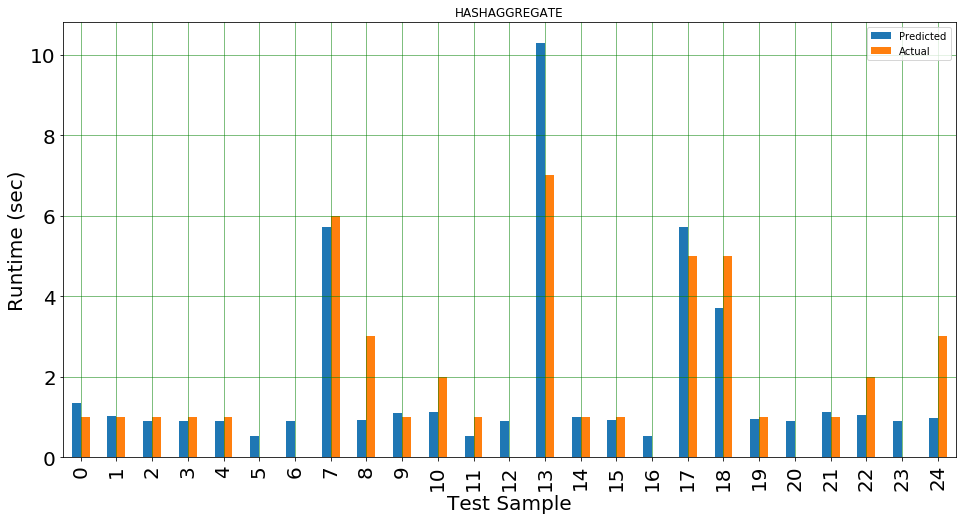

Median Absolute Error: 0.5287516206449339
Max RRS Error: 3.2903327442054877
Mean Absolute Error: 0.6635806629453136
Mean Squared Error: 0.7972949834486105
Root Mean Squared Error: 0.8929137603646897
Mean stage runtime: 1.2837837837837838
******************************************************* 



HASHAGGREGATE:BROADCASTNESTEDJOINLOOP , n_training 10 n_test 3 
              Coefficient
remote_read          0.0
cache_read           0.0
sequential           0.0
shuffle              0.0
aggregate            0.0 
intercept 0.6


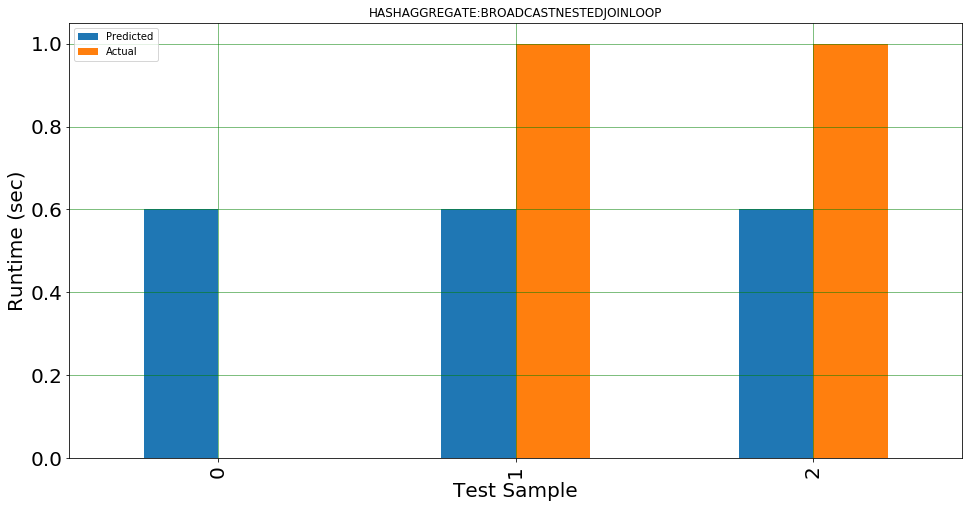

Median Absolute Error: 0.4
Max RRS Error: 0.6
Mean Absolute Error: 0.4666666666666666
Mean Squared Error: 0.22666666666666668
Root Mean Squared Error: 0.47609522856952335
Mean stage runtime: 0.6666666666666666
******************************************************* 



HASHAGGREGATE:FILTER , n_training 34 n_test 9 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   1.248088e-07
shuffle      6.908062e-06
aggregate    2.266039e-01 
intercept 0.6358274582530221


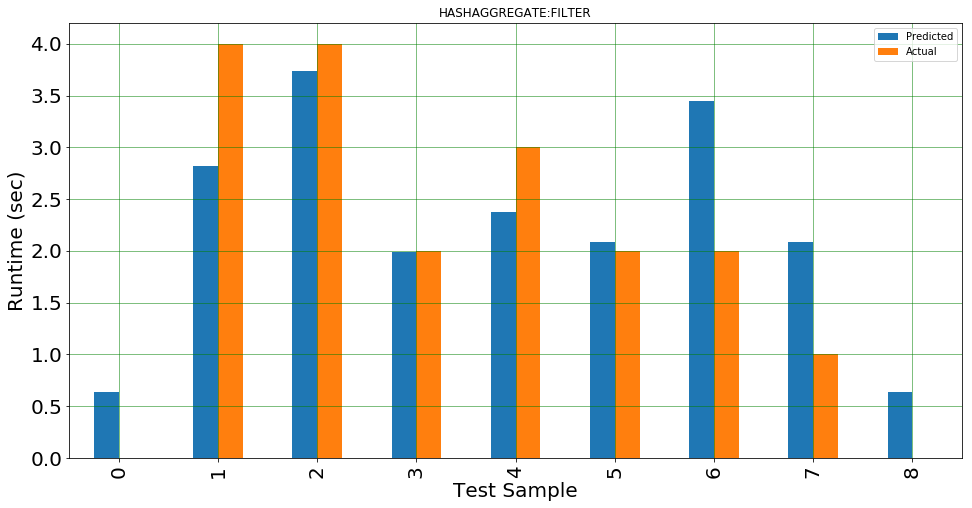

Median Absolute Error: 0.6363775343114854
Max RRS Error: 1.4490948197456168
Mean Absolute Error: 0.6637928111426225
Mean Squared Error: 0.6620859070204008
Root Mean Squared Error: 0.8136866147482094
Mean stage runtime: 2.0
******************************************************* 



SCAN , n_training 346 n_test 87 
               Coefficient
remote_read  1.267977e+00
cache_read   2.919999e+00
sequential   2.634123e-09
shuffle      2.913076e-03
aggregate    1.262615e+00 
intercept 3.4158645671145678


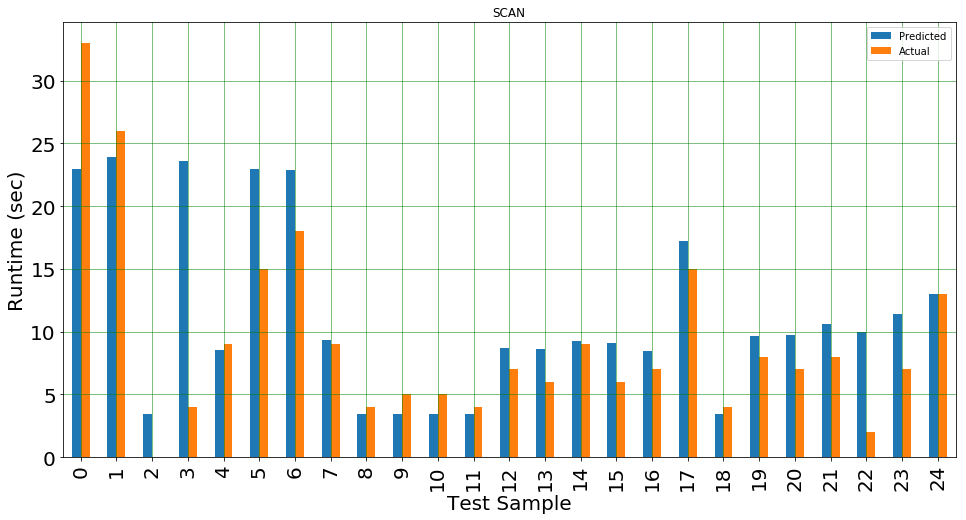

Median Absolute Error: 2.0744531372913286
Max RRS Error: 19.581672576161015
Mean Absolute Error: 3.342618211930628
Mean Squared Error: 25.05285406989669
Root Mean Squared Error: 5.005282616386081
Mean stage runtime: 12.574712643678161
******************************************************* 



SCAN:FILTER , n_training 245 n_test 62 
               Coefficient
remote_read  1.274875e+00
cache_read   1.906046e+00
sequential   6.878806e-09
shuffle      1.310510e-03
aggregate    1.425105e+00 
intercept 3.517668262856006


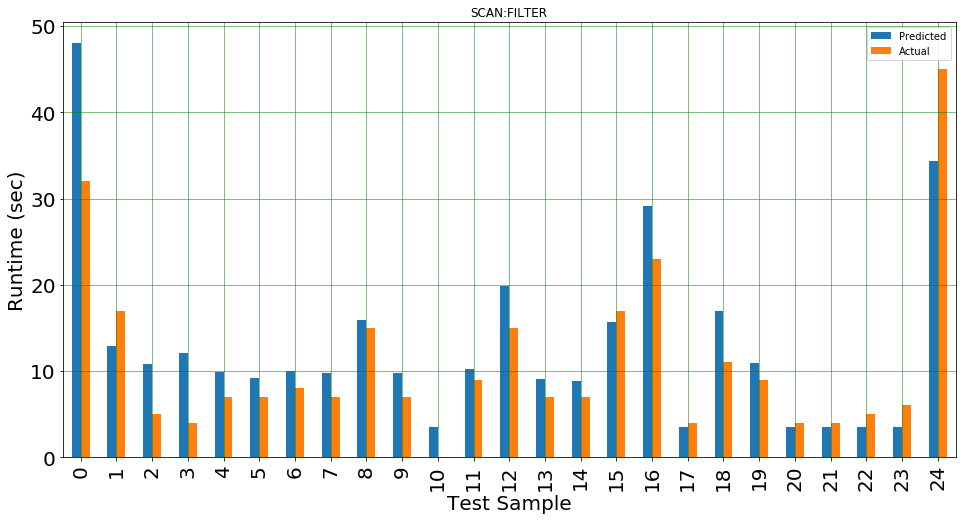

Median Absolute Error: 3.279002258915738
Max RRS Error: 72.10465138207398
Mean Absolute Error: 6.288059791192341
Mean Squared Error: 160.72524706609053
Root Mean Squared Error: 12.677746135101875
Mean stage runtime: 20.20967741935484
******************************************************* 



SCAN:FILTER:HASHAGGREGATE , n_training 68 n_test 18 
               Coefficient
remote_read  1.058663e+00
cache_read   2.807807e-01
sequential   1.374138e-08
shuffle      4.981266e-02
aggregate    0.000000e+00 
intercept 6.078007168504868


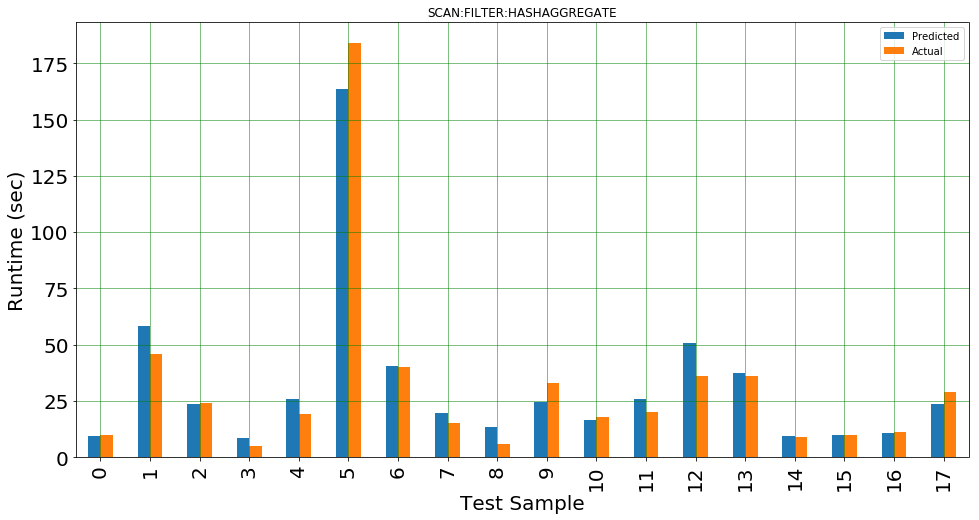

Median Absolute Error: 3.9762266678049265
Max RRS Error: 20.516258990983772
Mean Absolute Error: 5.253406344225772
Mean Squared Error: 58.72947214149924
Root Mean Squared Error: 7.663515651546569
Mean stage runtime: 30.61111111111111
******************************************************* 



SCAN:HASHAGGREGATE , n_training 26 n_test 7 
               Coefficient
remote_read  6.884009e-01
cache_read   0.000000e+00
sequential   7.936289e-08
shuffle      1.555714e-01
aggregate    0.000000e+00 
intercept -9.841361556654391


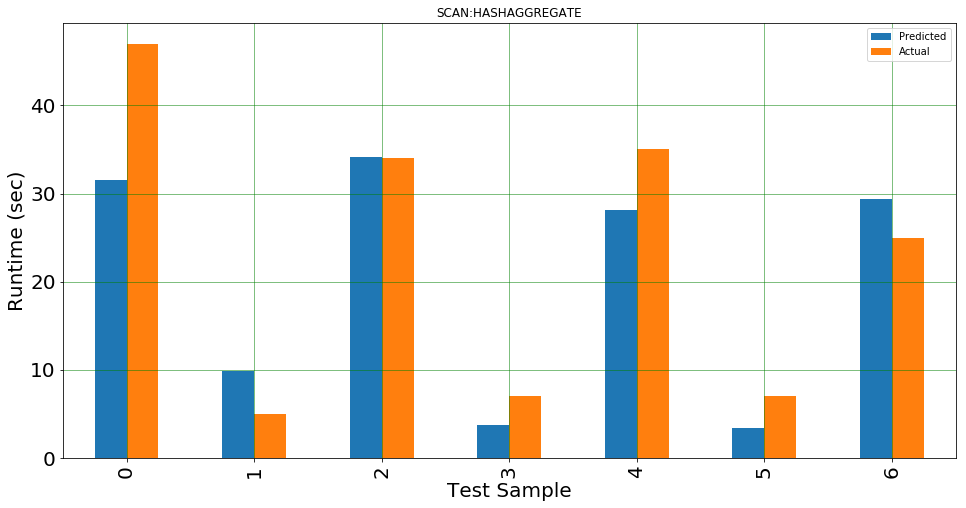

Median Absolute Error: 4.408058713546936
Max RRS Error: 15.498564865835732
Mean Absolute Error: 5.530621577949434
Mean Squared Error: 50.66966131475866
Root Mean Squared Error: 7.118262520781224
Mean stage runtime: 22.857142857142858
******************************************************* 



SORT , n_training 136 n_test 34 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   6.588259e-08
shuffle      1.916732e-03
aggregate    1.260623e-01 
intercept 0.44666506579579257


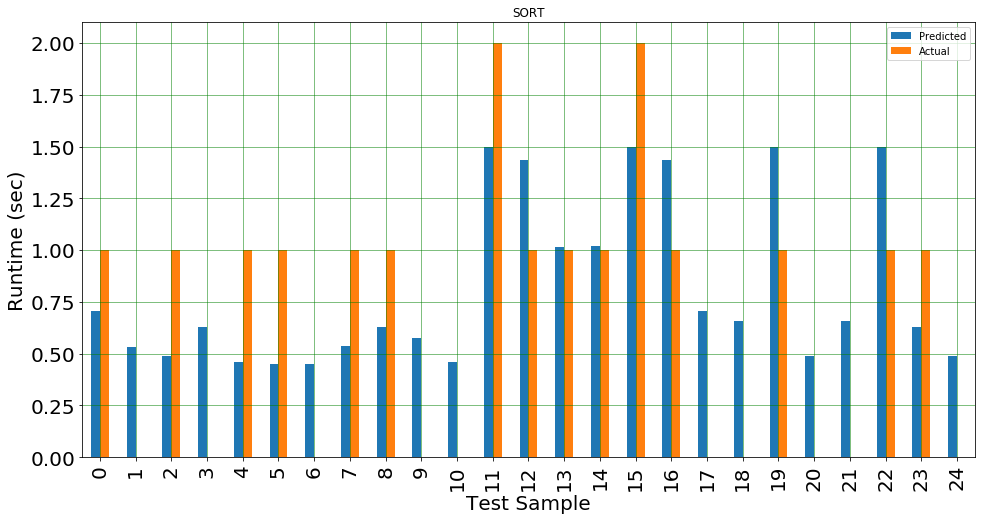

Median Absolute Error: 0.49874265816313534
Max RRS Error: 0.7053933987288323
Mean Absolute Error: 0.47780490119650987
Mean Squared Error: 0.24902257072679593
Root Mean Squared Error: 0.4990216134866264
Mean stage runtime: 0.6470588235294118
******************************************************* 



SORT:SORTMERGEJOIN , n_training 317 n_test 80 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   1.330900e-07
shuffle      0.000000e+00
aggregate    0.000000e+00 
intercept 2.9306153102507233


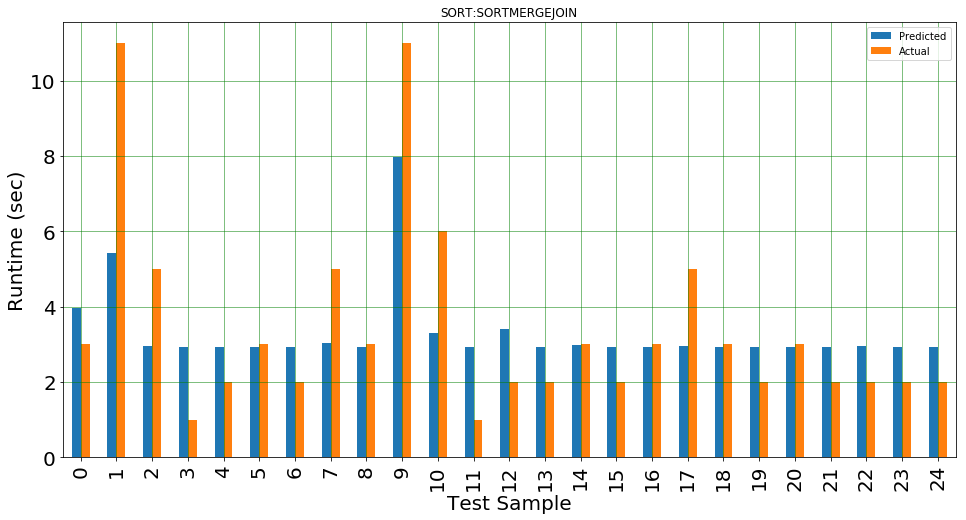

Median Absolute Error: 0.9453840475468742
Max RRS Error: 7.605004093612633
Mean Absolute Error: 1.5013132114133723
Mean Squared Error: 4.2693191602818965
Root Mean Squared Error: 2.066233084693471
Mean stage runtime: 3.5125
******************************************************* 



SORT:SORTMERGEJOIN:HASHAGGREGATE , n_training 179 n_test 45 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   1.628240e-07
shuffle      2.456795e-05
aggregate    5.836530e-01 
intercept 0.12135347601745883


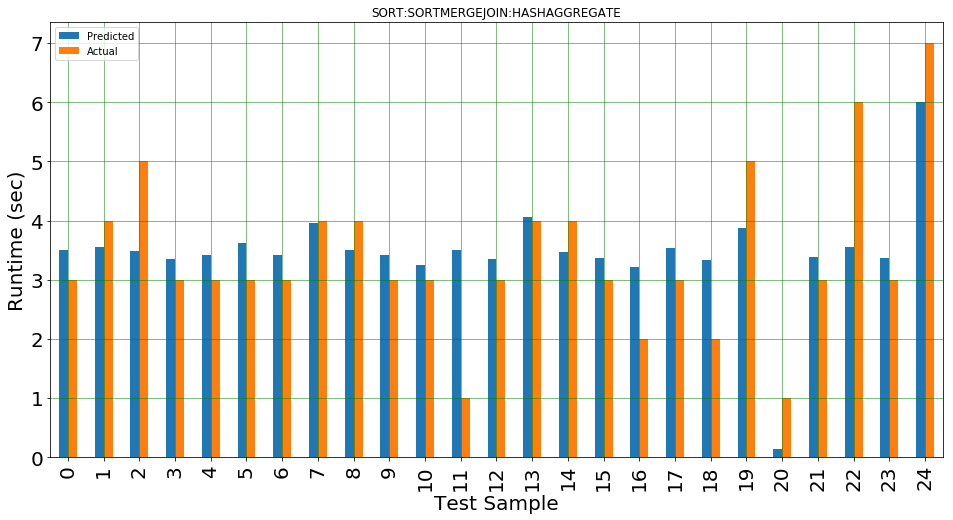

Median Absolute Error: 0.5336245177576782
Max RRS Error: 2.496972810827418
Mean Absolute Error: 0.7544334561216159
Mean Squared Error: 0.9054582927785476
Root Mean Squared Error: 0.9515557223718155
Mean stage runtime: 3.533333333333333
******************************************************* 



SORT:SORTMERGEJOIN:HASHAGGREGATE:FILTER , n_training 10 n_test 3 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   6.814520e-07
shuffle      0.000000e+00
aggregate    0.000000e+00 
intercept 4.1187782475861505


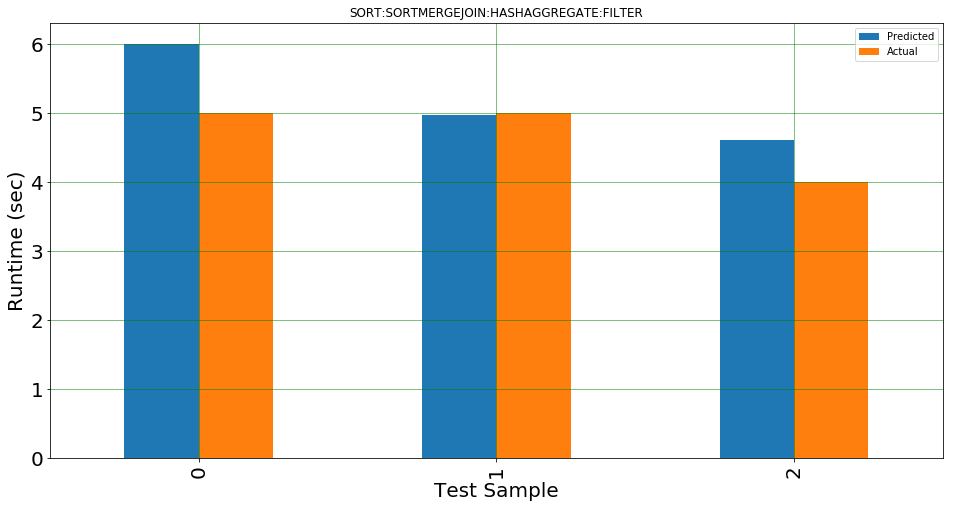

Median Absolute Error: 0.6123038141164274
Max RRS Error: 1.0106674310584989
Mean Absolute Error: 0.5501964075804352
Mean Squared Error: 0.4657091232229224
Root Mean Squared Error: 0.6824288411423731
Mean stage runtime: 4.666666666666667
******************************************************* 



SORT:SORTMERGEJOIN:HASHAGGREGATE:FILTER:BROADCASTHASHJOIN , n_training 17 n_test 5 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   6.780928e-07
shuffle      0.000000e+00
aggregate    0.000000e+00 
intercept 1.5543450707677091


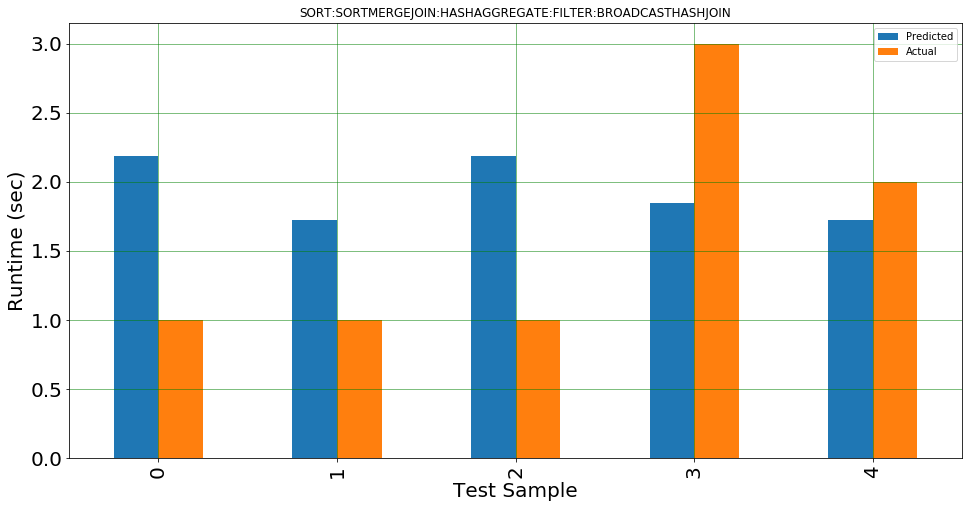

Median Absolute Error: 1.1540941608761068
Max RRS Error: 1.1885124673765812
Mean Absolute Error: 0.9061694876145306
Mean Squared Error: 0.9505772012127105
Root Mean Squared Error: 0.9749754874932551
Mean stage runtime: 1.6
******************************************************* 



WRITE , n_training 9 n_test 3 
              Coefficient
remote_read     0.000000
cache_read      0.000000
sequential      0.000821
shuffle         0.000000
aggregate       0.000000 
intercept -55.14458165276681


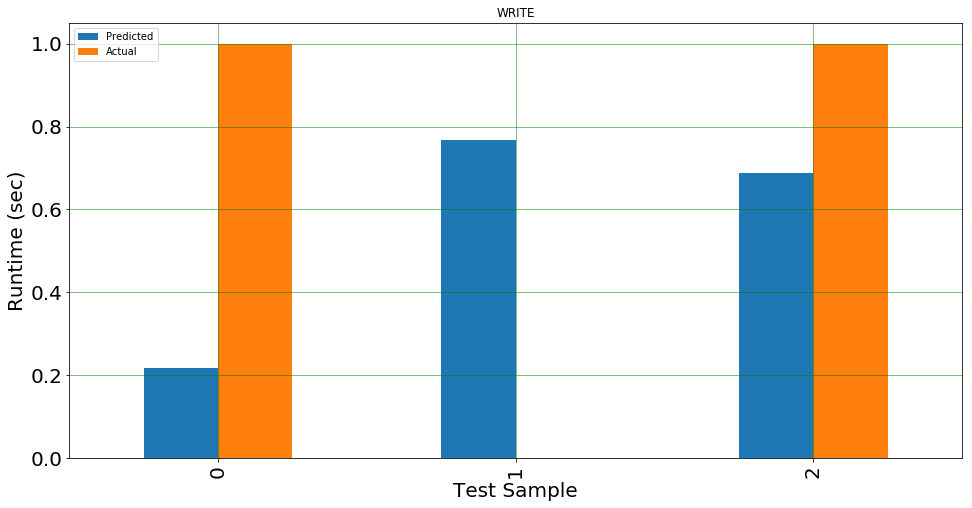

Median Absolute Error: 0.767030379152061
Max RRS Error: 0.7821044562662465
Mean Absolute Error: 0.6203013579682496
Mean Squared Error: 0.43240768037336363
Root Mean Squared Error: 0.6575771288399282
Mean stage runtime: 0.6666666666666666
******************************************************* 



skipped , n_training 8 n_test 3 
              Coefficient
remote_read     1.096063
cache_read      0.000000
sequential      0.000000
shuffle         0.000000
aggregate       0.000000 
intercept 0.784477456488166


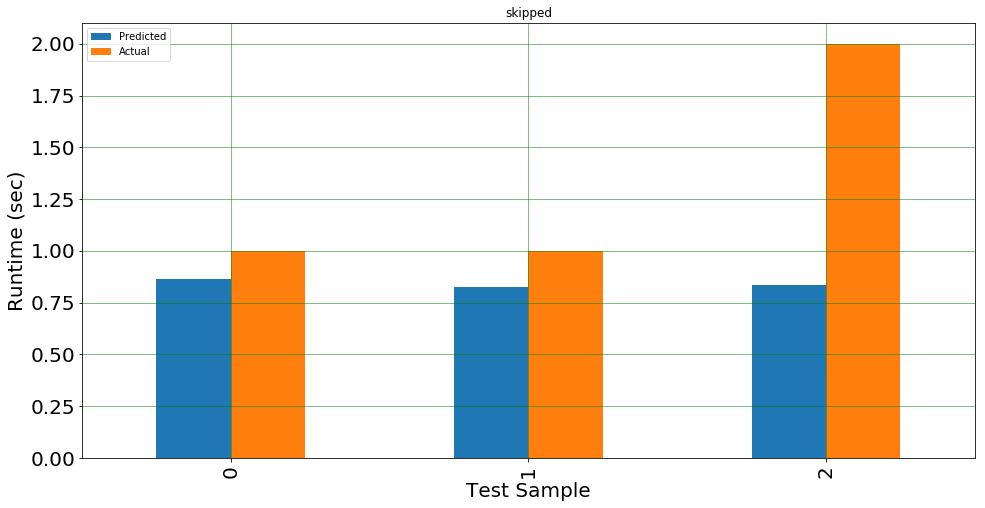

Median Absolute Error: 0.17579290977931827
Max RRS Error: 1.165942786933034
Mean Absolute Error: 0.49255959255134907
Mean Squared Error: 0.46960208359525674
Root Mean Squared Error: 0.6852751882238672
Mean stage runtime: 1.3333333333333333
******************************************************* 





In [1304]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

gdf2 = df2.groupby('feature')

regressors = {}

for index, df3 in gdf2:
    
    X = df3[['remote_read', 'cache_read', 'sequential', 'shuffle', 'aggregate']].values

    Y= df3['runtime'].values

    sc = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    #X_train = sc.fit_transform(X_train)
    #X_test = sc.transform(X_test)
    
    regressor = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
                positive=True, random_state=9999, selection='random')
    regressor.fit(X_train,y_train)
  #  regressor = LassoCV(max_iter=1000, positive=True, random_state=9999, selection='random')
  #  regressor.fit(X,Y)
    
    #print(X_test)
    #regressor = LinearRegression()  
    #regressor.fit(X_train, y_train)

    #if index == 'SCAN':
    #    coeff_df = pd.DataFrame(regressor.coef_, 
    #                            df3[['remote_read', 'cache_read', 'sequential']].columns, 
    #                            columns=['Coefficient'])  
    #else:
    coeff_df = pd.DataFrame(regressor.coef_, 
                            df3[['remote_read', 'cache_read', 'sequential', 'shuffle', 'aggregate']].columns, 
                            columns=['Coefficient'])  
    print(index, ', n_training', len(X_train), 'n_test', len(X_test),
          '\n', coeff_df, '\nintercept', regressor.intercept_)

    y_pred = regressor.predict(X_test)

    dn = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    dn['Accuracy'] = 100*(1 - dn['Predicted']/dn['Actual'])

    df1 = dn.head(25)

    fig, ax = plt.subplots(figsize=(16, 8))
    df1[['Predicted', 'Actual']].plot(kind='bar',ax=ax)
    ax.set_title(index)
    ax.set_xlabel('Test Sample', fontsize=20)
    ax.set_ylabel('Runtime (sec)', fontsize=20)
    ax.tick_params(labelsize=20)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    if index not in regressors: 
        regressors[index] = regressor; 
    
    print('Median Absolute Error:', metrics.median_absolute_error(y_test, y_pred))
    print('Max RRS Error:', metrics.max_error(y_test, y_pred))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean stage runtime:', y_test.mean())
    
    print('*******************************************************', '\n\n\n')
    


In [1216]:
def predict_runtime(row):
    logd = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']
    feature = row['feature']
    regressor = regressors[feature];
    input_sz = row['stage_input_bytes']
    cache_read =  row['prefetched_bytes']/bw_cache
    remote_read = np.abs(8*(row['stage_input_bytes'] - row['prefetched_bytes'])/(row['bw_i']*(10**9)))
    sequential = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']
    aggregate = np.log(row['numTasks'])
    shuffle = row['numTasks']#*dt['total_bytes']
    
    #sequential = (row['stage_input_bytes'] + row['stage_shuffle_read_bytes'])/row['numTasks']
    if logd == 0:
    #    aggregate = 0
        sort = 0
    else:
    #    aggregate = np.log(logd)
        sort = (logd)*np.log(logd)

    row['predict_runtime'] = round(regressor.predict([[remote_read, cache_read, sequential, shuffle, aggregate]])[0]
                                   ,2)
    if (input_sz > 0) & (app_index in to_be_shown):
        print('stage', row['stage_id'] , 'inputs', row['tables'], 'input size', input_sz,
              'prefetched ',row['prefetched_bytes'], 'bw', row['bw_i'],
              'remote', row['stage_input_bytes'] - row['prefetched_bytes'],
              'predict', row['predict_runtime'], 'actual', row['stage_run_time'], 
              'stride', row['stride'])

    return row


n_unique = df['app_id'].nunique()
n_test = 50 #int(n_unique*0.2)
print(n_unique, n_test)
test_apps_indexes = np.random.choice(df['app_id'].unique().shape[0], n_test, replace=False) 

to_be_shown = []
total=0
cp_err = 0
cp2_err = 0
for app_index in test_apps_indexes:
    #print(app_index)
    app_id = df['app_id'].unique()[app_index]
    app = df[df['app_id']==app_id].apply(predict_runtime, axis=1)
    
    #print(app['stage_id'])
    
    query = df[df['app_id']==app_id]['name'].values[0].replace('tpch', '')
    query_dag = df[df['app_id']==app_id]['app_dag'].values[0]
    g_id = sq_df[(sq_df['query']==int(query)) & (sq_df['dag'] == query_dag)]['id'].values[0]
    g = graphs_pool[g_id].copy()
    
    predicted_runtime = g.new_edge_property("float")
    actual_runtime = g.new_edge_property("float")

    for e in g.edges():
        v = e.source()
        # print(g.vp.vids[v], g.vp.feature[v])
        if g.vp.feature[v] == 'skipped':
            actual_runtime[e] = 0
            predicted_runtime[e] = 0
        else:
            actual_runtime[e], predicted_runtime[e] = -1*(app[app['stage_id']==int(g.vp.vids[v])][[
                'stage_run_time', 'predict_runtime']].values[0])
    
    g.ep['n_predicted_runtime'] = predicted_runtime
    g.ep['n_actual_runtime'] = actual_runtime
    
    roots = [v for v in g.vertices() if ((v.in_degree() == 0) & (g.vp.feature[v] != 'skipped'))]
    leaves = [v for v in g.vertices() if v.out_degree() == 0]
    #print(roots, leaves)
    
    predict_list= []
    for root in roots:
        for leaf in leaves:
            vlist, elist = gt.shortest_path(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_predicted_runtime, 
                                            negative_weights=True, pred_map=None)
            
            dist = gt.shortest_distance(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_predicted_runtime, 
                                            negative_weights=True, pred_map=None)
            
            vlist1, elist1 = gt.shortest_path(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_actual_runtime,
                                           negative_weights=True, pred_map=None)
            dist1 = gt.shortest_distance(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_actual_runtime, 
                                            negative_weights=True, pred_map=None)
            
            
            #print('path from %d to %d: predicted lat %0.2f, actual lat %0.2f'%(root, leaf, 
            #                                                                 round(-1*dist, 2), -1*dist1))
            
            predict_list.append({'root': root, 'leaf': leaf, 'predicted':  round(-1*dist, 2), 'actual': -1*dist1,
                                'ppath': vlist, 'apath': vlist1})
     #       for v in vlist:
     #           print('predicted', v)
            
     #       for v in vlist1:
     #           print('actual', v)
    dcp = pd.DataFrame(predict_list)
    #print(dcp['predicted'].idxmax(), dcp['actual'].idxmax()) 
    if dcp['predicted'].idxmax() != dcp['actual'].idxmax():
        cp_err += 1
        print(app_index)
    else:
        pred_1s2nd_cp = dcp['predicted'].nlargest(2).index.values
        if len(pred_1s2nd_cp) > 1:
            index_2nd_pred_cp = dcp['predicted'].nlargest(2).index.values[1]
            index_2nd_actual_cp = dcp['actual'].nlargest(2).index.values[1:]
            
            #cp2_err += (index_2nd_pred_cp in index_2nd_actual_cp)
            
            if index_2nd_pred_cp not in index_2nd_actual_cp:
                print(app_id, df[df['app_id']==app_id]['app_name'].values[0])
                cp2_err += 1
                print(dcp[['root', 'leaf', 'actual', 'predicted']])
            
#        actual_2nd_cp = dcp[dcp['actual'] == dcp['actual'].nlargest(2)][['root', 'leaf']]
#        predicted_2nd_cp = dcp[dcp['predicted'] == dcp['predicted'].nlargest(2)][['root', 'leaf']]
        
        #if (actual_2nd_cp[0] == predicted_2nd_cp[0]) and (actual_2nd_cp[1] == predicted_2nd_cp[1]):
        #    print('correct 2nd cp')
        pass
    #    
    total += 1
    #print('************************************* NEXTTTTTTTTT *************************************')
    if app_index in to_be_shown:
        print(app_id, df[df['app_id']==app_id]['app_name'].values[0])
        gt.graph_draw(g, vertex_text=g.vertex_index, vertex_color=g.vp.color, 
                      vertex_fill_color=g.vp.color, size=(700, 700))
        print(dcp[['root', 'leaf', 'predicted', 'actual', 'ppath', 'apath']])
   #     break

cp_err, cp2_err, total

234 50
app-20200906180245-0257 framework:spark-name:tpch11-bw:40Gbps-ds:32G-stride:50-random:yzysjafl
  root leaf  actual  predicted
0    0   18    15.0      11.97
1    1   18    16.0      17.32
2    3   18    14.0      15.65
3    8   18    11.0      16.15
app-20200905194943-0155 framework:spark-name:tpch2-bw:5Gbps-ds:64G-stride:80-random:iycnqczq
  root leaf  actual  predicted
0    0   17    16.0      18.71
1    1   17    16.0      19.90
2    3   17    16.0      22.46
3    5   17    22.0      27.35
4    7   17     8.0      18.04
5    8   17    13.0      19.80
6    9   17    14.0      23.55
7   12   17    11.0      19.11
49
app-20200906102415-0207 framework:spark-name:tpch5-bw:5Gbps-ds:32G-stride:30-random:jkyutdzx
  root leaf  actual  predicted
0    0   24    30.0      23.49
1    1   24    31.0      23.39
2    3   24    30.0      25.99
3    5   24    63.0      63.93
4    7   24    26.0      26.72
5    9   24    12.0      15.31
151
app-20200906163258-0231 framework:spark-name:tpch5-bw:

(3, 5, 50)

In [1245]:
print(df[df['stride'] == '0']['app_id'].nunique())

n_unique = df['app_id'].nunique()
n_test = df[(df['stride'] == '0') | (df['stride'] == '10')]['app_id'].nunique() #int(n_unique*0.2)

print(n_unique, n_test)
test_apps_indexes2 = np.random.choice(df[(df['stride'] == '0') | (df['stride'] == '10')]['app_id'].unique().shape[0], n_test, replace=False)

cp_results = []

to_be_shown = []
total2=0
cp_err2 = 0
cp2_err2 = 0
for app_index in test_apps_indexes2:
    app_id = df[(df['stride'] == '0') | (df['stride'] == '10')]['app_id'].unique()[app_index]
    app = df[df['app_id']==app_id].apply(predict_runtime, axis=1)
     
    query = df[df['app_id']==app_id]['name'].values[0].replace('tpch', '')
    dataset = df[df['app_id']==app_id]['ds'].values[0];
    bw = df[df['app_id']==app_id]['bw'].values[0];
    
    
    query_dag = df[df['app_id']==app_id]['app_dag'].values[0]
    g_id = sq_df[(sq_df['query']==int(query)) & (sq_df['dag'] == query_dag)]['id'].values[0]
    g = graphs_pool[g_id].copy()
    
    predicted_runtime = g.new_edge_property("float")
    actual_runtime = g.new_edge_property("float")

    for e in g.edges():
        v = e.source()
        if g.vp.feature[v] == 'skipped':
            actual_runtime[e] = 0
            predicted_runtime[e] = 0
        else:
            actual_runtime[e], predicted_runtime[e] = -1*(app[app['stage_id']==int(g.vp.vids[v])][[
                'stage_run_time', 'predict_runtime']].values[0])
    
    g.ep['n_predicted_runtime'] = predicted_runtime
    g.ep['n_actual_runtime'] = actual_runtime
    
    roots = [v for v in g.vertices() if ((v.in_degree() == 0) & (g.vp.feature[v] != 'skipped'))]
    leaves = [v for v in g.vertices() if v.out_degree() == 0]
    
    predict_list= []
    for root in roots:
        for leaf in leaves:
            vlist, elist = gt.shortest_path(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_predicted_runtime, 
                                            negative_weights=True, pred_map=None)
            
            dist = gt.shortest_distance(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_predicted_runtime, 
                                            negative_weights=True, pred_map=None)
            
            vlist1, elist1 = gt.shortest_path(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_actual_runtime,
                                           negative_weights=True, pred_map=None)
            dist1 = gt.shortest_distance(g, g.vertex(root), g.vertex(leaf), weights=g.ep.n_actual_runtime, 
                                            negative_weights=True, pred_map=None)
            
            predict_list.append({'root': root, 'leaf': leaf, 'predicted':  round(-1*dist, 2), 'actual': -1*dist1,
                                'ppath': vlist, 'apath': vlist1})
            
    
    cps_df = pd.DataFrame(predict_list)
    if cps_df['predicted'].idxmax() != cps_df['actual'].idxmax():
        cp_err2 += 1
        print(int(query), bw, dataset, cps_df['predicted'].max(), cps_df['actual'].max())
        print(cps_df[['actual', 'predicted']].sort_values('actual'))
        #to_be_shown.append(app_index)
    else:
        cp_results.append({'query': int(query), 'dataset': dataset, 
                           'bandwidth': bw, 'predicted': cps_df['predicted'].max(),
                          'actual': cps_df['actual'].max()})
        pred_1s2nd_cp = cps_df['predicted'].nlargest(2).index.values
        if len(pred_1s2nd_cp) > 1:
            index_2nd_pred_cp = cps_df['predicted'].nlargest(2).index.values[1]
            index_2nd_actual_cp = cps_df['actual'].nlargest(2).index.values[1:]
            
            if index_2nd_pred_cp not in index_2nd_actual_cp:
                cp2_err2 += 1
                print('second', int(query), bw, dataset)
                print(cps_df[['actual', 'predicted']].sort_values('actual'))
                
    total2 += 1
    if app_index in to_be_shown:
        print(app_id, df[df['app_id']==app_id]['app_name'].values[0])
        gt.graph_draw(g, vertex_text=g.vertex_index, vertex_color=g.vp.color, 
                      vertex_fill_color=g.vp.color, size=(700, 700))
        print(dcp[['root', 'leaf', 'predicted', 'actual', 'ppath', 'apath']])

print(cp_err2, cp2_err2, total2)

cp_df = pd.DataFrame(cp_results)
cp_df['accuracy'] = (cp_df['actual']/cp_df['predicted'])
cp_df = cp_df.round({'accuracy': 2}).sort_values(by='query').reset_index(drop=True)

cp_df[['query', 'dataset', 'bandwidth', 'actual', 'predicted', 'accuracy']].sort_values('actual')

17
234 37
second 5 10Gbps 20G
   actual  predicted
5    14.0      13.81
4    22.0      20.21
0    24.0      22.25
1    24.0      22.15
2    24.0      24.02
3    42.0      37.20
16 20Gbps 64G 24.6 19.0
   actual  predicted
2    17.0      18.03
0    19.0      21.19
1    19.0      24.60
second 2 1Gbps 20G
   actual  predicted
0    17.0      18.27
5    17.0      18.81
1    18.0      18.91
2    20.0      20.40
6    21.0      20.94
7    22.0      20.29
4    23.0      19.75
3    42.0      42.29
second 20 20Gbps 20G
   actual  predicted
1    11.0      10.59
0    13.0      15.28
2    18.0      19.38
3    18.0      20.54
4    29.0      26.99
second 2 1Gbps 32G
   actual  predicted
0    16.0      18.39
1    16.0      19.18
5    16.0      19.08
6    23.0      22.04
4    27.0      23.45
7    27.0      24.12
2    30.0      21.35
3    58.0      57.95
second 9 10Gbps 64G
   actual  predicted
0    16.0      20.04
1    18.0      27.32
3    30.0      35.14
4    32.0      28.35
5    36.0      28.10
2    8

,query,dataset,bandwidth,actual,predicted,accuracy
11,6,20G,20Gbps,15.0,19.44,0.77
33,22,32G,10Gbps,17.0,31.68,0.54
32,22,32G,10Gbps,18.0,26.99,0.67
23,16,20G,20Gbps,18.0,19.93,0.90
20,14,20G,20Gbps,18.0,20.53,0.88
18,13,32G,40Gbps,18.0,17.98,1.00
34,22,20G,40Gbps,19.0,23.44,0.81
29,19,20G,40Gbps,19.0,19.02,1.00
22,16,32G,5Gbps,22.0,26.08,0.84
7,4,20G,40Gbps,23.0,21.85,1.05


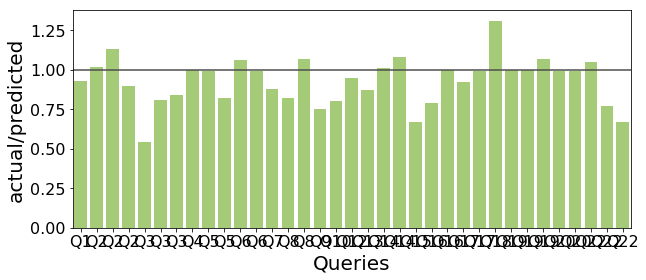

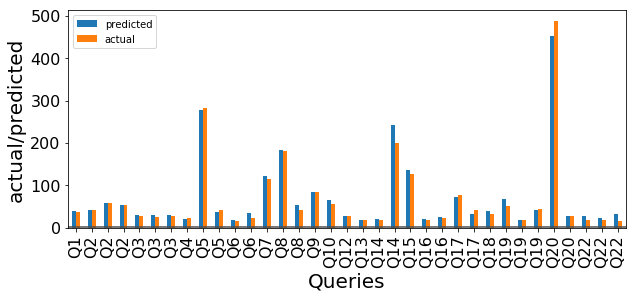

In [1188]:
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib.ticker as ticker
import seaborn as sns

def format_xticks(x, pos=None):
    return 'Q%s'%(cp_df.iloc[x]['query'])


fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=cp_df.index, y="accuracy", ax = ax, data=cp_df, color='#a6d96a')
ax.axhline(1, color='#4d4d4d')
ax.set_ylabel('actual/predicted', fontsize=20)
ax.set_xlabel('Queries', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=16)

fig, ax = plt.subplots(figsize=(10, 4))
cp_df[['predicted', 'actual']].plot.bar(ax = ax)
ax.axhline(1, color='#4d4d4d')
ax.set_ylabel('actual/predicted', fontsize=20)
ax.set_xlabel('Queries', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=16)


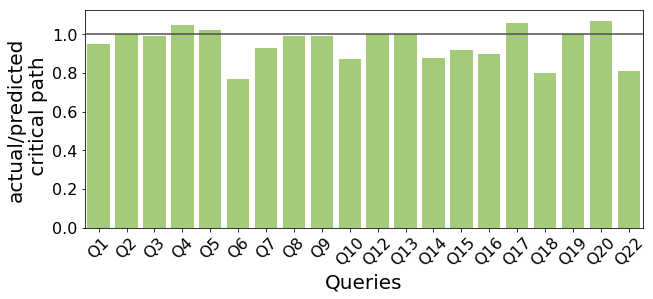

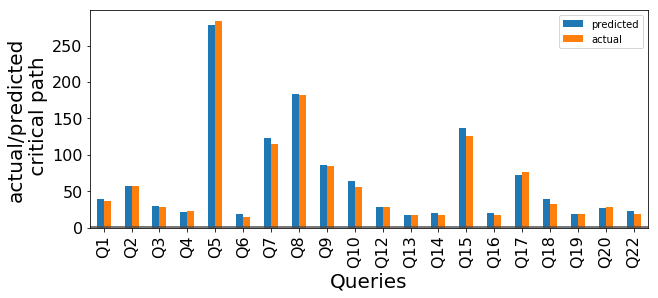

In [1214]:
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib.ticker as ticker
import seaborn as sns

def format_xticks(x, pos=None):
    return 'Q%s'%(final_cp_df.iloc[x]['query'])


def max_accuracy(grp):
    return np.abs(grp['accuracy'] - 1).idxmin()

gps = cp_df.groupby('query').apply(max_accuracy).values
final_cp_df = cp_df.iloc[gps , :]


fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=final_cp_df.index, y="accuracy", ax = ax, data=final_cp_df, color='#a6d96a')
ax.axhline(1, color='#4d4d4d')
ax.set_ylabel('actual/predicted\n critical path', fontsize=20)
ax.set_xlabel('Queries', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=16)
plt.xticks(rotation=45)


fig, ax = plt.subplots(figsize=(10, 4))
final_cp_df[['predicted', 'actual']].plot.bar(ax = ax)
ax.axhline(1, color='#4d4d4d')
ax.set_ylabel('actual/predicted\n critical path', fontsize=20)
ax.set_xlabel('Queries', fontsize=20)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
ax.tick_params(labelsize=16)




In [1246]:
(np.abs(final_cp_df['accuracy'] - 1)).mean()

0.07

SCAN:FILTER:HASHAGGREGATE 
               Coefficient
remote_read  1.071496e+00
cache_read   8.409758e-01
sequential   8.770844e-09 
 9.463336943230836


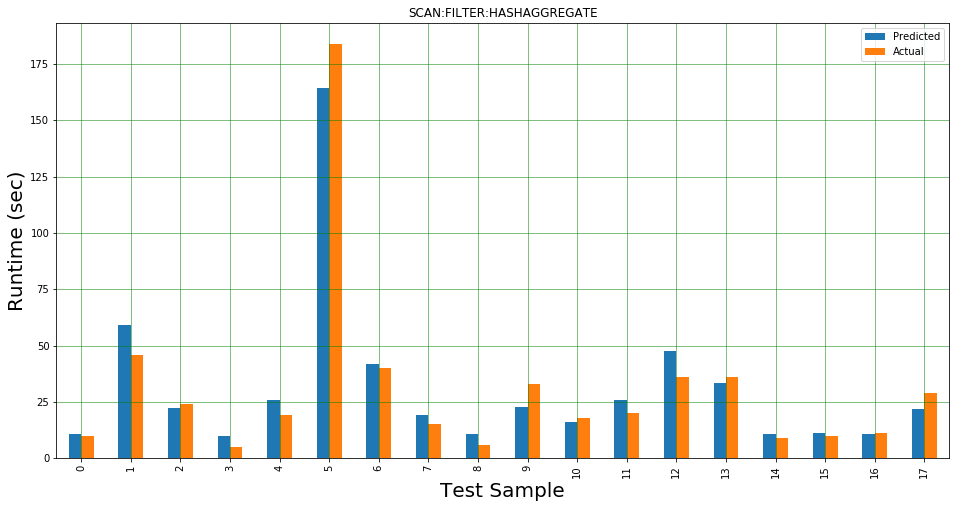

Mean Absolute Error: 5.5741443062009175
Mean Squared Error: 56.47532414773636
Root Mean Squared Error: 7.515006596652884
Mean stage runtime: 30.61111111111111
******************************************************* 





In [1229]:
gdf2 = df2.groupby('feature')

for index, df3 in gdf2:
    if index != 'SCAN:FILTER:HASHAGGREGATE':
        continue
    
    X = df3[['remote_read', 'cache_read', 'sequential']].values

    Y= df3['runtime'].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    regressor = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
                positive=True, random_state=9999, selection='random')
  #  regressor = LassoCV(max_iter=1000, positive=True, random_state=9999, selection='random')
    regressor.fit(X_train,y_train)
    
    coeff_df = pd.DataFrame(regressor.coef_, 
                            df3[['remote_read', 'cache_read', 'sequential']].columns, 
                            columns=['Coefficient'])  
    print(index, '\n', coeff_df, '\n', regressor.intercept_)

    y_pred = regressor.predict(X_test)

    dn = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    dn['Accuracy'] = 100*(1 - dn['Predicted']/dn['Actual'])

    df1 = dn.head(25)

    fig, ax = plt.subplots(figsize=(16, 8))
    df1[['Predicted', 'Actual']].plot(kind='bar',ax=ax)
    ax.set_title(index)
    ax.set_xlabel('Test Sample', fontsize=20)
    ax.set_ylabel('Runtime (sec)', fontsize=20)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean stage runtime:', y_test.mean())
    
    print('*******************************************************', '\n\n\n')
    break


In [1271]:
print(df2.columns)
gps = df.groupby(['feature', 'bw', 'ds', 'prefetched_blocks'])
gps.ngroups, len(df)

Index(['prefetched_bytes', 'feature', 'input_sz', 'cache_read', 'remote_read',
       'sequential', 'aggregate', 'sort', 'shuffle', 'runtime', 'app_name',
       'stage_id', 'tables'],
      dtype='object')


(559, 2133)

In [1318]:
for index, group in gps:
    #print(group['app_name'])
    if index != ('SCAN', '10Gbps', '32G', 0):
        continue
    print(index, len(group))
    #print(group.columns)
    
    dfg = pd.DataFrame()
    dfg['prefetched_bytes'] = group['prefetched_bytes']
    dfg['feature'] = group['feature']
    dfg['input_sz'] = group['stage_input_bytes']
    dfg['cache_read'] =  group['prefetched_bytes']/bw_cache
    dfg['remote_read'] = np.abs(8*(group['stage_input_bytes'] - group['prefetched_bytes'])/(group['bw_i']*(10**9)))
    dfg['sequential'] = (group['stage_input_bytes'] + group['stage_shuffle_read_bytes'])/group['numTasks']
    dfg['aggregate'] = np.log(group['numTasks'])#df.apply(get_aggregate, axis=1) #np.log((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])
    dfg['sort'] = group.apply(get_sort, axis=1) #((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])*np.log((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'])
    dfg['shuffle'] = (group['numTasks'])#*dt['total_bytes']
    dfg['runtime'] = group['stage_run_time']
    dfg['app_name'] = group['app_name']
    dfg['stage_id'] = group['stage_id']
    dfg['tables'] = group['tables']
    
    X = dfg[['remote_read', 'cache_read', 'sequential', 'shuffle', 'aggregate']].values
    Y= dfg['runtime'].values

    y_pred = regressor.predict(X)
    
    sum_errors = 0
    for ys in zip(Y, y_pred):
        sum_errors += (ys[0] - ys[1])**2
    
    print(np.sqrt(sum_errors/(len(Y) - 1)), np.sqrt(sum_errors/(len(Y))), np.max(Y), np.mean(Y), np.min(Y))
    
    
    break

('SCAN', '10Gbps', '32G', 0) 10
4.287820154891264 4.067783365989709 7.0 4.4 1.0


In [1314]:
df['sequentials'] = np.round((df['stage_input_bytes'] + df['stage_shuffle_read_bytes'])/df['numTasks'], 2)

df[df['feature'] == 'HASHAGGREGATE'][['stage_input_bytes', 'stage_shuffle_read_bytes', 
       'numTasks', 'sequentials', 'stage_run_time', 'app_id', 'stage_id']].sort_values('sequentials')

,stage_input_bytes,stage_shuffle_read_bytes,numTasks,sequentials,stage_run_time,app_id,stage_id
1121,0,22004,200,110.02,2.0,app-20200906090521-0183,1
259,0,22004,200,110.02,1.0,app-20200905124745-0039,3
1118,0,22004,200,110.02,1.0,app-20200906090521-0183,3
1617,0,22004,200,110.02,2.0,app-20200906164916-0237,1
1614,0,22004,200,110.02,0.0,app-20200906164916-0237,3
262,0,22004,200,110.02,3.0,app-20200905124745-0039,1
528,0,22004,200,110.02,2.0,app-20200905170110-0116,1
525,0,22004,200,110.02,0.0,app-20200905170110-0116,3
236,0,30800,200,154.00,1.0,app-20200905123920-0036,3
231,0,30800,200,154.00,1.0,app-20200905123920-0036,7


In [1320]:
gdf2 = df2.groupby('feature')


for index, df3 in gdf2:
    if index == 'SORT:SORTMERGEJOIN':
        break

df3[(df3['feature'] == 'SORT:SORTMERGEJOIN') & (df3['input_sz'] > 0)]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style="whitegrid")
